
Transform start......
Transform done!


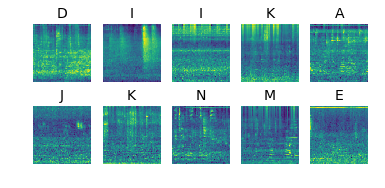

In [21]:
#coding=utf-8
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
# from scipy import ndimage
import skimage.io as io
from PIL import Image
from scipy.stats import norm




def get_files(file_dir):
    '''
    Args:
        file_dir: file directory
    Returns:
        list of images and labels
    '''
    # bus = []
    # label_bus = []
    # beach = []
    # label_beach = []

    image_list=[]
    label_list=[]
    for file in os.listdir(file_dir):
        image_list.append(file_dir+file)
    # print image_list
    txtfile="/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/txt/train.txt"
    with open(txtfile) as f:
        lst1=f.readlines()
        for i in lst1:
            m=i.split()
            label_list.append(int(m[1]))
        # print label_list




    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp)

    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(i) for i in label_list]

    return image_list, label_list

def int64_feature(value):
    """Wrapper for inserting int64 features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# %%

def convert_to_tfrecord(images, labels, save_dir, name):
    '''convert all images and labels to one tfrecord file.
    Args:
        images: list of image directories, string type
        labels: list of labels, int type
        save_dir: the directory to save tfrecord file, e.g.: '/home/folder1/'
        name: the name of tfrecord file, string type, e.g.: 'train'
    Return:
        no return
    Note:
        converting needs some time, be patient...
    '''

    filename = os.path.join(save_dir, name + '.tfrecords')
    n_samples = len(labels)

    if np.shape(images)[0] != n_samples:
        raise ValueError('Images size %d does not match label size %d.' % (images.shape[0], n_samples))

    # wait some time here, transforming need some time based on the size of your data.
    writer = tf.python_io.TFRecordWriter(filename)
    print('\nTransform start......')
    for i in np.arange(0, n_samples):
        try:
            image = io.imread(images[i])  # type(image) must be array!
            # image=Image.open(images[i])#我把上面的改成了这个
            image_raw = image.tostring()
            # image_raw=image.tobytes()#我将上面这个也改了，将图片转化成二进制格式
            label = int(labels[i])
            example = tf.train.Example(features=tf.train.Features(feature={
                'label': int64_feature(label),
                'image_raw': bytes_feature(image_raw)}))
            writer.write(example.SerializeToString())
        except IOError as e:
            print('Could not read:', images[i])
            print('error: %s' % e)
            print('Skip it!\n')
    writer.close()
    print('Transform done!')


# %%

def read_and_decode(tfrecords_file, batch_size):
    '''read and decode tfrecord file, generate (image, label) batches
    Args:
        tfrecords_file: the directory of tfrecord file
        batch_size: number of images in each batch
    Returns:
        image: 4D tensor - [batch_size, width, height, channel]
        label: 1D tensor - [batch_size]
    '''
    # make an input queue from the tfrecord file
    #创建一个reader来读取TFRecord文件中的样例
    reader = tf.TFRecordReader()
    #创建一个队列来维护输入文件列表
    filename_queue = tf.train.string_input_producer([tfrecords_file])
    #从文件中读出一个样例，也可以使用read_up_to一次读取多个样例
    _, serialized_example = reader.read(filename_queue)
    # 解析读入的一个样例，如果需要解析多个，可以用parse_example
    img_features = tf.parse_single_example(
        serialized_example,
        features={
            'label': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string),
        })

    image = tf.decode_raw(img_features['image_raw'], tf.uint8)

    ##########################################################
    # you can put data augmentation here, I didn't use it
    ##########################################################
    # all the images of notMNIST are 28*28, you need to change the image size if you use other dataset.

    image = tf.reshape(image, [100, 100])
    image=tf.cast(image,tf.float32)
    label = tf.cast(img_features['label'], tf.int32)
    image_batch, label_batch = tf.train.batch([image, label],
                                              batch_size=batch_size,
                                              num_threads=64,
                                              capacity=2000)


    label_batch=tf.reshape(label_batch, [batch_size])
    ##==iadd
    # image_batch = tf.cast(image_batch, tf.float32)
    return image_batch, label_batch


# def get_random_data(data,batch_size):
#     start_index=np.random.randint((0,len(data)-batch_size))
#     k=data[start_index:(start_index+batch_size)]
#     return k


#Convert data to TFRecord
#=======================start===============================
#下面是测试上面的代码是否可行

BATCH_SIZE = 10
file_dir="/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/train/"
save_dir="/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/"


name = 'train'
images, labels = get_files(file_dir)
convert_to_tfrecord(images, labels, save_dir, name)


# %% TO test train.tfrecord file

def plot_images(images, labels):
    '''plot one batch size
    '''
    for i in np.arange(0, BATCH_SIZE):
        plt.subplot(5, 5, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[i] - 1), fontsize=14)
        plt.subplots_adjust(top=1.5)
        plt.imshow(images[i])
    plt.show()



tfrecords_file='/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/train.tfrecords'
image_batch, label_batch = read_and_decode(tfrecords_file, batch_size=BATCH_SIZE)

with tf.Session()  as sess:
    i = 0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    try:
        while not coord.should_stop() and i < 1:
            # just plot one batch size
            image, label = sess.run([image_batch, label_batch])
            plot_images(image, label)
            i += 1

    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)

#==================================end====================================



In [22]:
learning_rate = 0.001 #学习率
num_steps = 5000  #迭代次数
batch_size = 1 #每次迭代选取的样本数

# Network Parameters
image_dim = 10000 # dcase images are 28x28 pixels，输入层神经元个数
hidden_dim = 512 #编码层/解码层神经元个数
latent_dim = 2 #隐藏层神经元个数

In [23]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.)) #返回正态分布随机数

# define Variables：用字典的方式存储各隐藏层的参数
# 权重weight和偏置bias的变化，在编码层和解码层顺序是相逆的
# 权重参数矩阵维度是该层的 输入*输出[784,10] ，偏置参数维度取决于该层 输出层的单元数[10]
#画图来讲
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}


In [24]:
# Building the encoder
#因为encoder一般是神经网络模型
# 故每一层结构都是 xW + b （看图）
# 构建编码器
input_image = tf.placeholder(tf.float32, shape=[None, image_dim]) #输入数据,
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
#采样隐变量z，输入到decoder中去“重构”图片
#首先得构造一个服从标准正态分布的随机变量：eps
#利用eps和z_mean,z_std去合成z，使得z服从高斯分布，
#此时梯度也能进行回传
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)



In [25]:
# Define VAE Loss定义损失函数
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss 使得重构图片与原始图片的差异最小
    # encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         # + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss=-tf.reduce_mean(x_true*tf.log(tf.clip_by_value(x_reconstructed,1e-10,1.0)))
    # encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss 使得z的分布与标准正态分布之间的差异最小
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)#总的差异是这两者的差异相加

loss_op = vae_loss(decoder, input_image) #创建实例，调用方法
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate) #调用优化器进行优化
train_op = optimizer.minimize(loss_op)

summary_op = tf.summary.merge_all()

file_dir = "/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/train/"
save_dir = "/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/"
logs_train_dir='/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/log3/'
name = 'train'
tfrecords_file = '/home/lu/dcase/zhy/mytensorflow/dcase_vae/data3/train.tfrecords'

images, labels =get_files(file_dir)
convert_to_tfrecord(images, labels, save_dir, name)
image_batch, label_batch =read_and_decode(tfrecords_file, batch_size=12)
# Initialize the variables (i.e. assign their default value)




Transform start......
Transform done!


In [26]:
# Start Training 开始训练
# Start a new TF session 创建一个tensorflow会话，所有的计算图都要在会话中执行
sess = tf.Session()
train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)
saver = tf.train.Saver()

# Run the initializer
init = tf.global_variables_initializer() #初始化所有变量
sess.run(init)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
# Training

for i in range(1, num_steps+1):
    # Prepare Data准备数据
    # Get the next batch of MNIST data (only images are needed, not labels)
    #取得下一个训练数据样本（由于样本太大，需要分批次训练）
    # batch_x, _ = mnist.train.next_batch(batch_size)

    # image_list,label_list=tfrecord_input.get_files(file_dir)
    # total_batch=len(image_list)


    val, lu = sess.run([image_batch, label_batch])
    # print val.shape,lu
    val = val.reshape([12,100*100])

    # train, train_label = image_batch,label_batch

    # batch_x= image_batch
    # 报错：喂到网络里的值不能为张量，必须为list，string
    # batch_x=Image.open(batch_x)
    # batch_x=np.array(batch_x)
    # batch_x=image_batch.flatten()
    # batch_x=image_batch.reshape(-1,10000)

    # batch,_=input.get_files(train_dir)



#修改：这里要喂我们自己的数据

    # Train ，每一批训练完以后，将其他训练批次的样本数据喂给输入

    feed_dict = {input_image:val}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 100 == 0 or i == 1: #从第一次迭代开始，每隔1000次打印一次迭代次数以及损失率
        print('Step %i, Loss: %f' % (i, l))
    if i % 100==0:
        saver_path=saver.save(sess,'./model/model.cpkt')
    # Testing 测试
    # Generator takes noise as input
    # 把含有噪声的数据当作隐变量（本质上就是高斯随机分布向量）输入到decoder中
    # （此时decoder就相当于一个图片生成器了）
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

    # Rebuild the decoder to create image from noise
    # 重建decoder，由给的高斯随机分布向量中去生成新的图片（此处有不足，可改进）
    decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
    decoder = tf.nn.tanh(decoder)
    decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
    decoder = tf.nn.sigmoid(decoder)


Step 1, Loss: 94.716919
Step 100, Loss: 15.749476
Step 200, Loss: 2.433768
Step 300, Loss: 3.727225
Step 400, Loss: 3.523069
Step 500, Loss: 3.291661
Step 600, Loss: 1.177022
Step 700, Loss: 0.962240
Step 800, Loss: 1.302249
Step 900, Loss: 3.630852
Step 1000, Loss: 4.107080
Step 1100, Loss: 2.444055
Step 1200, Loss: 2.342877
Step 1300, Loss: 2.600013
Step 1400, Loss: 3.135662
Step 1500, Loss: 0.875970
Step 1600, Loss: 2.955749
Step 1700, Loss: 1.589327
Step 1800, Loss: 2.652173
Step 1900, Loss: 1.986598
Step 2000, Loss: 0.637493
Step 2100, Loss: 0.298291
Step 2200, Loss: 0.054212
Step 2300, Loss: 0.095099
Step 2400, Loss: 0.063506
Step 2500, Loss: 0.115242
Step 2600, Loss: 0.101429
Step 2700, Loss: 0.096928
Step 2800, Loss: 0.098030
Step 2900, Loss: 0.098730
Step 3000, Loss: 0.098384
Step 3100, Loss: 0.098072
Step 3200, Loss: 0.098243
Step 3300, Loss: 0.098415
Step 3400, Loss: 0.098338
Step 3500, Loss: 0.099274
Step 3600, Loss: 0.098332
Step 3700, Loss: 0.097806
Step 3800, Loss: 0.098

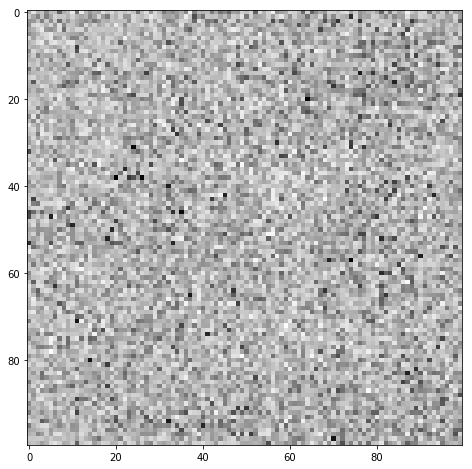

In [33]:
# Building a manifold of generated digits
    # 可视化生成的图片（主要用到matplot.pylot和numpy库中的相关函数）
n = 1  # 一张20×20的可视化图
x_axis = np.linspace(-3, 3, n)  # 函数返回20个具有相同间隔的采样值，数据的间隔通过计算获得
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((100 * n, 100 * n))  # 创建一个28×20行，28×20列的随机矩阵
for i, yi in enumerate(x_axis):  # python的内建函数，返回索引，元素值
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)  # 返回一个2维数组
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})  # 通过feed_dict给noise_input传值
        canvas[(n - i - 1) * 100:(n - i) * 100, j * 100:(j + 1) * 100] = \
                x_mean[0].reshape(100, 100)

plt.figure(figsize=(8, 8))  # 指定绘图对象的分辨率，宽8×80像素，高10×80像素
Xi, Yi = np.meshgrid(x_axis, y_axis)  # 产生两个维度相同的矩阵
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()